<a href="https://colab.research.google.com/github/elhamod/BA820/blob/main/Hands-on/01-association-rules/association_rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyzing Trends at a Grocery Store.

## In this notebook, we will analyze the transactions at a grocery store and extract some customer behavior that is of interest to us.

In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

## Load the data

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/elhamod/BA820/main/Hands-on/01-association-rules/Kaggle_GroceryStoreDataSet_modified.csv"

df = pd.read_csv(url, header=None)
# In case there are too many rows to load, you can use this parameter:  nrows = 100)

df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
0,"MILK,BREAD,BISCUIT"
1,"BREAD,MILK,BISCUIT,CORNFLAKES"
2,"BREAD,TEA,BOURNVITA"
3,"JAM,MAGGI,BREAD,MILK"
4,"BREAD,TEA,BOURNVITA"


## Analyze data

Convert the text in the table to a list of items

In [3]:
data_column = df.iloc[:, 0]
data = list(data_column.apply(lambda x: x.split(',')))
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['MILK', 'BREAD', 'BISCUIT'],
 ['BREAD', 'MILK', 'BISCUIT', 'CORNFLAKES'],
 ['BREAD', 'TEA', 'BOURNVITA'],
 ['JAM', 'MAGGI', 'BREAD', 'MILK'],
 ['BREAD', 'TEA', 'BOURNVITA'],
 ['MAGGI', 'TEA', 'BISCUIT'],
 ['MAGGI', 'TEA', 'CORNFLAKES'],
 ['MAGGI', 'BREAD', 'TEA', 'BISCUIT'],
 ['JAM', 'MAGGI', 'BREAD', 'TEA'],
 ['', 'BREAD', 'MILK'],
 ['CAFE', 'COKE', 'BISCUIT', 'CORNFLAKES'],
 ['COFFEE', 'COCACOLA', 'BISCUIT', 'CORNFLAKES'],
 ['COFFEE', 'SUGER', 'BOURNVITA'],
 ['BREAD', 'CAFE', 'COKE'],
 ['BREAD', 'SUGER', 'BISCUIT'],
 ['COFFEE', 'SUGER', 'CORNFLAKES'],
 ['BREAD', 'SUGER', 'BOURNVITA'],
 ['BREAD', 'CAFE', 'SUGER'],
 ['BREAD', 'CAFE', 'SUGER'],
 ['TEA', 'MILK', 'COFFEE', 'CORNFLAKES']]

Out of curiousity, what are the unique values?

In [4]:
flat_list = []
for lst in data:
  flat_list = flat_list + lst
set(flat_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'',
 'BISCUIT',
 'BOURNVITA',
 'BREAD',
 'CAFE',
 'COCACOLA',
 'COFFEE',
 'COKE',
 'CORNFLAKES',
 'JAM',
 'MAGGI',
 'MILK',
 'SUGER',
 'TEA'}

Seems we have a couple of things to attend to:


1.   An empty string.
2.   COFFEE and CAFE are the same item.
3.   COKE and COCACOLA are the same product.

Let's clean up the data

In [5]:
for indx, lst in enumerate(data):
  # Remove empty strings:
  lst = [i for i in lst if i]

  # Replace CAFE with COFFEE
  lst = ['COFFEE' if i == 'CAFE' else i for i in lst]

  # Replace COCACOLA with COKE
  lst = ['COKE' if i == 'COCACOLA' else i for i in lst]

  # Update data
  data[indx] = lst

data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['MILK', 'BREAD', 'BISCUIT'],
 ['BREAD', 'MILK', 'BISCUIT', 'CORNFLAKES'],
 ['BREAD', 'TEA', 'BOURNVITA'],
 ['JAM', 'MAGGI', 'BREAD', 'MILK'],
 ['BREAD', 'TEA', 'BOURNVITA'],
 ['MAGGI', 'TEA', 'BISCUIT'],
 ['MAGGI', 'TEA', 'CORNFLAKES'],
 ['MAGGI', 'BREAD', 'TEA', 'BISCUIT'],
 ['JAM', 'MAGGI', 'BREAD', 'TEA'],
 ['BREAD', 'MILK'],
 ['COFFEE', 'COKE', 'BISCUIT', 'CORNFLAKES'],
 ['COFFEE', 'COKE', 'BISCUIT', 'CORNFLAKES'],
 ['COFFEE', 'SUGER', 'BOURNVITA'],
 ['BREAD', 'COFFEE', 'COKE'],
 ['BREAD', 'SUGER', 'BISCUIT'],
 ['COFFEE', 'SUGER', 'CORNFLAKES'],
 ['BREAD', 'SUGER', 'BOURNVITA'],
 ['BREAD', 'COFFEE', 'SUGER'],
 ['BREAD', 'COFFEE', 'SUGER'],
 ['TEA', 'MILK', 'COFFEE', 'CORNFLAKES']]

## Market Basket Analysis

We now have the data in a basket format. We need to convert it into a encoded format.

In [6]:
# Transform data
te = TransactionEncoder()
te_data = te.fit(data).transform(data)

# Create a dataframe from the data
df_encoded = pd.DataFrame(te_data, columns=te.columns_)
df_encoded

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,BISCUIT,BOURNVITA,BREAD,COFFEE,COKE,CORNFLAKES,JAM,MAGGI,MILK,SUGER,TEA
0,True,False,True,False,False,False,False,False,True,False,False
1,True,False,True,False,False,True,False,False,True,False,False
2,False,True,True,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,True,True,True,False,False
4,False,True,True,False,False,False,False,False,False,False,True
5,True,False,False,False,False,False,False,True,False,False,True
6,False,False,False,False,False,True,False,True,False,False,True
7,True,False,True,False,False,False,False,True,False,False,True
8,False,False,True,False,False,False,True,True,False,False,True
9,False,False,True,False,False,False,False,False,True,False,False


Let's find the most frequent itemsets.

In [7]:
frequent_itemsets = apriori(df_encoded, min_support=0.00001, use_colnames=True)
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.35,(BISCUIT)
1,0.20,(BOURNVITA)
2,0.65,(BREAD)
3,0.40,(COFFEE)
4,0.15,(COKE)
...,...,...
78,0.05,"(MAGGI, TEA, BREAD, BISCUIT)"
79,0.10,"(COKE, CORNFLAKES, BISCUIT, COFFEE)"
80,0.05,"(MAGGI, BREAD, MILK, JAM)"
81,0.05,"(MAGGI, TEA, BREAD, JAM)"


Let's find the rules of interest.

In [8]:
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.05) #, metric="confidence", min_threshold=0.6
rules.sort_values(by="support")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
167,(MILK),"(CORNFLAKES, BREAD)",0.25,0.05,0.05,0.200000,4.000000,0.0375,1.187500,1.000000
225,(TEA),"(MILK, COFFEE)",0.35,0.05,0.05,0.142857,2.857143,0.0325,1.108333,1.000000
224,"(MILK, COFFEE)",(TEA),0.05,0.35,0.05,1.000000,2.857143,0.0325,inf,0.684211
223,"(TEA, COFFEE)",(MILK),0.05,0.25,0.05,1.000000,4.000000,0.0375,inf,0.789474
222,"(TEA, MILK)",(COFFEE),0.05,0.40,0.05,1.000000,2.500000,0.0300,inf,0.631579
...,...,...,...,...,...,...,...,...,...,...
47,(COFFEE),(SUGER),0.40,0.30,0.20,0.500000,1.666667,0.0800,1.400000,0.666667
69,(TEA),(MAGGI),0.35,0.25,0.20,0.571429,2.285714,0.1125,1.750000,0.865385
68,(MAGGI),(TEA),0.25,0.35,0.20,0.800000,2.285714,0.1125,3.250000,0.750000
34,(BREAD),(MILK),0.65,0.25,0.20,0.307692,1.230769,0.0375,1.083333,0.535714


Let's filter the rules further.

In [9]:
rules_filtered = rules[(rules['confidence'] > 0.5) & (rules['lift'] >= 1)]
rules_filtered.sort_values(by="confidence")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
69,(TEA),(MAGGI),0.35,0.25,0.20,0.571429,2.285714,0.1125,1.75,0.865385
4,(COKE),(BISCUIT),0.15,0.35,0.10,0.666667,1.904762,0.0475,1.95,0.558824
290,(COKE),"(CORNFLAKES, BISCUIT, COFFEE)",0.15,0.10,0.10,0.666667,6.666667,0.0850,2.70,1.000000
287,"(CORNFLAKES, BISCUIT)","(COKE, COFFEE)",0.15,0.15,0.10,0.666667,4.444444,0.0775,2.55,0.911765
286,"(COKE, COFFEE)","(CORNFLAKES, BISCUIT)",0.15,0.15,0.10,0.666667,4.444444,0.0775,2.55,0.911765
...,...,...,...,...,...,...,...,...,...,...
223,"(TEA, COFFEE)",(MILK),0.05,0.25,0.05,1.000000,4.000000,0.0375,inf,0.789474
224,"(MILK, COFFEE)",(TEA),0.05,0.35,0.05,1.000000,2.857143,0.0325,inf,0.684211
102,"(COKE, BISCUIT)",(COFFEE),0.10,0.40,0.10,1.000000,2.500000,0.0600,inf,0.666667
240,"(MAGGI, MILK)",(JAM),0.05,0.10,0.05,1.000000,10.000000,0.0450,inf,0.947368


## Let's do some analysis through visualizations.

Some necessary string manipulation to beautify the visualization labels.

In [10]:
rules_filtered['antecedents'] = rules_filtered['antecedents'].apply(lambda a: ','.join(list(a)))
rules_filtered['consequents'] = rules_filtered['consequents'].apply(lambda a: ','.join(list(a)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-2f02268e6f11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_filtered['antecedents'] = rules_filtered['antecedents'].apply(lambda a: ','.join(list(a)))
<ipython-input-10-2f02268e6f11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

I want to see the support for each antecedent-consequent pair.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='consequents', ylabel='antecedents'>

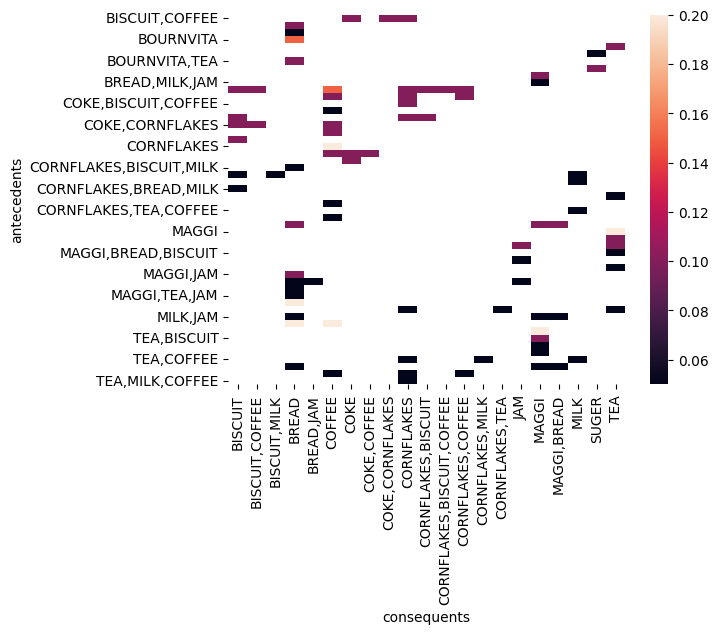

In [11]:
import seaborn as sns

support_table = rules_filtered.pivot(index='antecedents', columns='consequents',
values='support')
sns.heatmap(support_table)

I want to see how the support for the antecedent and consequent, respectively, contrast with lift.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='antecedent support', ylabel='consequent support'>

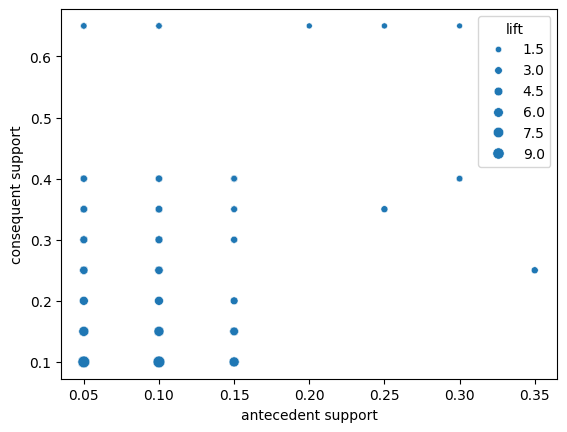

In [12]:
sns.scatterplot(x="antecedent support", y="consequent support", size="lift", data=rules_filtered)

## Questions worth investigating


*   Get some stats on the dataset, such as the average number of transactions per person and the 10 most frequent transactions.
*   Filter the rules down to those that are useful for promoting items to customers once they have 3 items in their cart.
*   If you have an excess of tea that is expiring soon in your stock and you want to sell it out quickly, which customer base would you promote it to?
*   How does the computational complexity (i.e., how long it takes the algorithm to run) change as we change the number of transactions and/or our filtering criteria. One could use the `%%timeit`.

